<a href="https://colab.research.google.com/github/rmahesh6386/Tata-Motors-Project-/blob/main/TATA_Motors_Stock_market_Forecasting_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [135]:
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics

plt.style.use("ggplot")

%matplotlib inline

In [137]:
plt.rcParams["figure.figsize"] = (12, 6)

In [138]:
# For reading stock data from yahoo
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

# For time stamps
from datetime import datetime

# For division
from __future__ import division

In [139]:
#stock Company for analytics
stock = ['TATAMOTORS.NS']
data_source = 'yahoo' 

# set up Start and End time for data grab
end = datetime.now()
start = datetime(end.year-10,end.month,end.day)

# Set DataFrame as the Stock Ticker
df = pdr.get_data_yahoo(stock,start,end)

[*********************100%***********************]  1 of 1 completed


In [140]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-07-27,208.266144,213.114136,206.979935,210.591202,208.192703,11852257
2012-07-30,214.103531,220.435608,213.064667,219.347275,216.849045,9094027
2012-07-31,219.644104,224.591034,214.845566,223.848999,221.299500,11297966
2012-08-01,222.167038,227.262390,220.831360,224.937317,222.375427,10425962
2012-08-02,223.700592,224.591034,219.248337,220.336670,217.827179,5808700


In [141]:
df.index

DatetimeIndex(['2012-07-27', '2012-07-30', '2012-07-31', '2012-08-01',
               '2012-08-02', '2012-08-03', '2012-08-06', '2012-08-07',
               '2012-08-08', '2012-08-09',
               ...
               '2022-07-14', '2022-07-15', '2022-07-18', '2022-07-19',
               '2022-07-20', '2022-07-21', '2022-07-22', '2022-07-25',
               '2022-07-26', '2022-07-27'],
              dtype='datetime64[ns]', name='Date', length=2464, freq=None)

Check whether you have duplicate data on by date

In [142]:
df[df.index.duplicated(keep = False)]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,


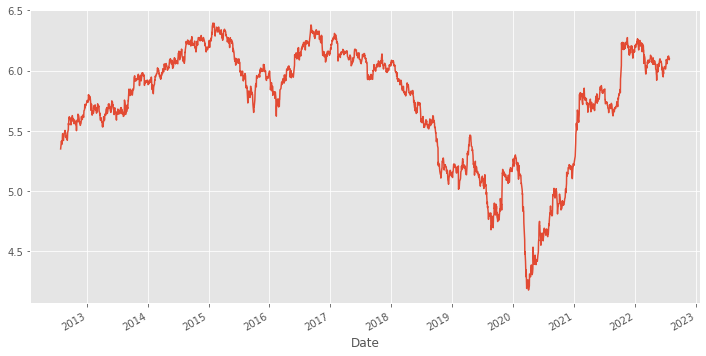

In [143]:
y = np.log(df["Close"])
y.plot()

In [144]:
y.index

DatetimeIndex(['2012-07-27', '2012-07-30', '2012-07-31', '2012-08-01',
               '2012-08-02', '2012-08-03', '2012-08-06', '2012-08-07',
               '2012-08-08', '2012-08-09',
               ...
               '2022-07-14', '2022-07-15', '2022-07-18', '2022-07-19',
               '2022-07-20', '2022-07-21', '2022-07-22', '2022-07-25',
               '2022-07-26', '2022-07-27'],
              dtype='datetime64[ns]', name='Date', length=2464, freq=None)

Calculate rolling mean, exponentially weighted mean

In [145]:
period = 100
y_rolling = pd.DataFrame(dict(actual = y, 
                              rolling_mean = y.rolling(period).mean(), 
                              ewm = y.ewm(span = period).mean()
                             ))
y_rolling.tail()

,actual,rolling_mean,ewm
Date,,,
2022-07-21,6.119968,6.052305,6.060416
2022-07-22,6.120078,6.052198,6.061597
2022-07-25,6.108247,6.052099,6.062521
2022-07-26,6.089385,6.051954,6.063053
2022-07-27,6.095937,6.052111,6.063704


In [146]:
rolling_dropped = y_rolling.dropna()
print("rmse over rolling mean: ", metrics.mean_squared_error(rolling_dropped.actual, rolling_dropped.rolling_mean) ** 0.5)
print("rmse over ewma: ", metrics.mean_squared_error(rolling_dropped.actual, rolling_dropped["ewm"]) ** 0.5)

rmse over rolling mean:  0.18584831697866364
rmse over ewma:  0.15795918070246967


By visual inspection, we see the time series is not stationary. Let we will see a more formal way of testing using Dickey Fullter Test.

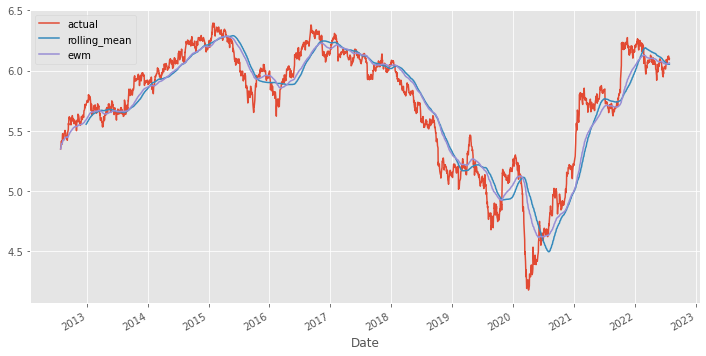

In [147]:
y_rolling.plot()

Formal of way of test for stationarity. Since the p-value of Augmented Dickey Fullter test is > 0.05, we can say that there is not sufficient proof that the time series is stationary. Loosely speaking, it is non-stationary. We need further transformation to make data stationary. Populary method for making data stationary will be to take "difference". Taking difference by lag one, we see the p-val for Dickey Fuller test is < 0.05. So we conclude, diff 1 has made the data stationary.

In [148]:
from statsmodels.tsa.stattools import adfuller
def check_stationarity(series):
    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

check_stationarity(y.dropna())

ADF Statistic: -1.412390
p-value: 0.576322
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Non-stationary


In [149]:
diff = pd.DataFrame({"actual": y, "diff1": y.diff(3)}).head(10)
diff["diff2"] = diff.diff1.diff(1)
diff

,actual,diff1,diff2
Date,,,
2012-07-27,5.349919,NaN,NaN
2012-07-30,5.390656,NaN,NaN
2012-07-31,5.410972,NaN,NaN
2012-08-01,5.415822,0.065903,NaN
2012-08-02,5.395157,0.004500,-0.061402
2012-08-03,5.387268,-0.023704,-0.028205
2012-08-06,5.423271,0.007450,0.031154
2012-08-07,5.464957,0.069801,0.062351
2012-08-08,5.476201,0.088933,0.019132


In [150]:
def check_stationarity(series):
    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

check_stationarity(y.diff(periods=1).dropna())

ADF Statistic: -48.587787
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Stationary


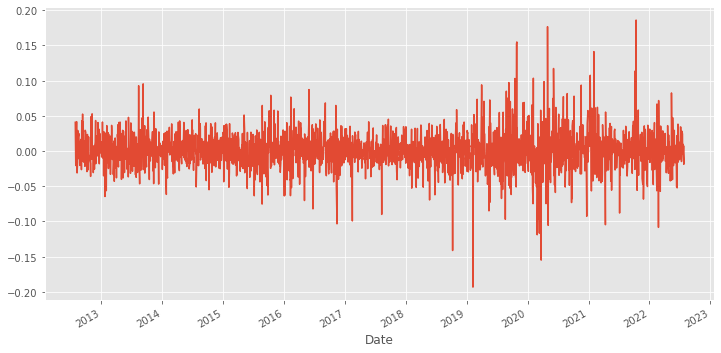

In [151]:
y.diff(periods=1).plot()

Use pandas's auto correlation plot. Here is a nice explanation of the autocorrelation plot

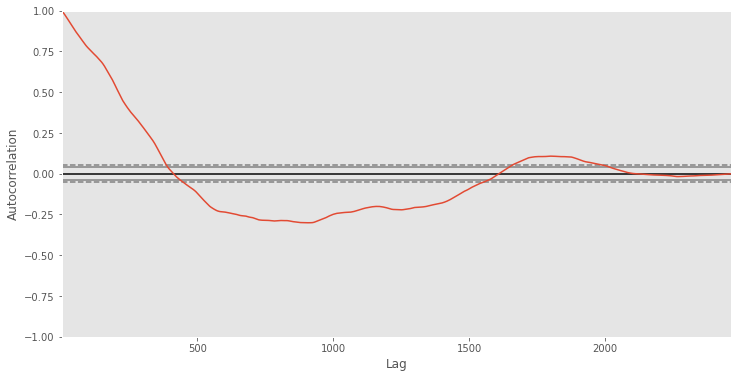

In [152]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(y)

In [153]:
y = y.dropna()

In [154]:
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

model_autoARIMA = auto_arima(y, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10827.559, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10826.650, Time=0.56 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10826.631, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10829.246, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-10824.900, Time=0.86 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.602 seconds
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 2464
Model:               SARIMAX(0, 1, 0)   Log Likelihood                5415.623
Date:                Wed, 27 Jul 2022   AIC                         -10829.246
Time:                        17:09:43   BIC                         -10823.436
Sample:                             0   HQIC                        -10827.135
                               - 2464                             

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                  0
count  2.463000e+03
mean   4.470395e-10
std    2.684729e-02
min   -1.936780e-01
25%   -1.358745e-02
50%   -3.028897e-04
75%    1.318318e-02
max    1.857344e-01


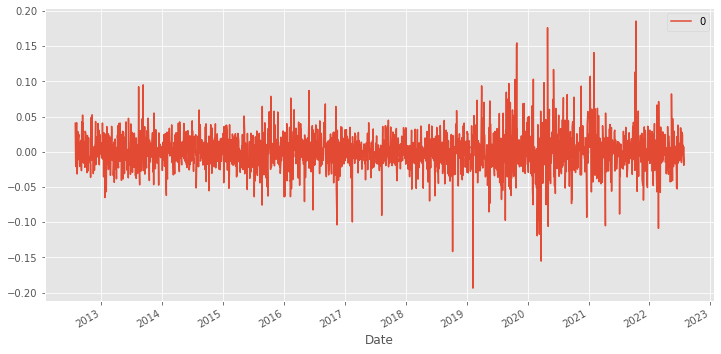

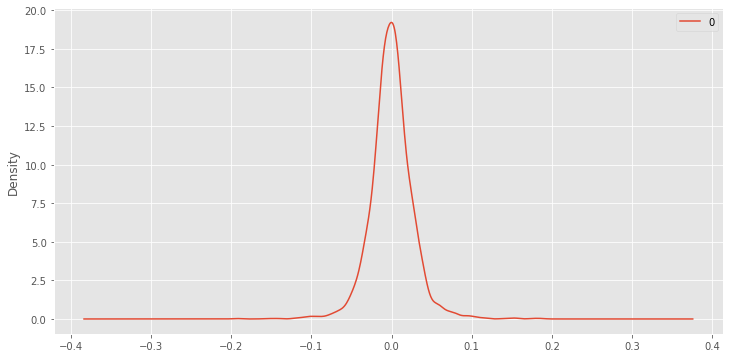

In [155]:
from statsmodels.tsa.arima_model import ARIMA

p=0
d=1
q=0

# fit model
model = ARIMA(y, order=(p, d, q)) 
model_fit = model.fit(disp=0)
#print(model_fit.summary())

# plot residual erros
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
residuals.plot(kind='kde')
print(residuals.describe())

In [156]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 2463
Model:                 ARIMA(0, 1, 0)   Log Likelihood                5415.780
Method:                           css   S.D. of innovations              0.027
Date:                Wed, 27 Jul 2022   AIC                         -10827.559
Time:                        17:09:44   BIC                         -10815.941
Sample:                             1   HQIC                        -10823.338
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.560      0.576      -0.001       0.001
==============================================================================
"""

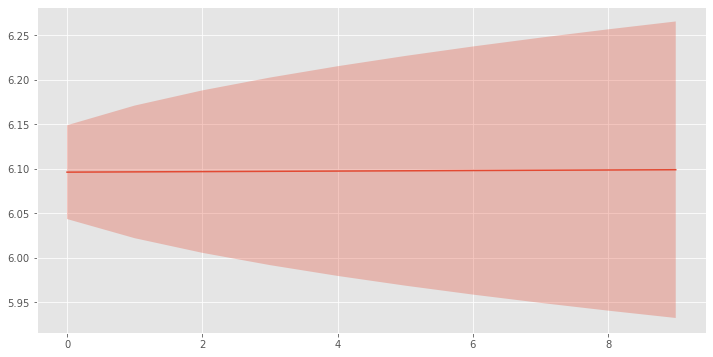

In [157]:
model = ARIMA(y.values, order=(p, d, q))
model_fit = model.fit(disp=0)
predictions, error, conf_interval = model_fit.forecast(10)
plt.plot(predictions)
plt.fill_between(range(len(predictions)), conf_interval[:,0], conf_interval[:,1], alpha = 0.3)

In [158]:
predictions[:10]

array([6.09624003, 6.09654292, 6.09684581, 6.0971487 , 6.09745159,
       6.09775448, 6.09805737, 6.09836026, 6.09866315, 6.09896604])

In [162]:
from sklearn.metrics import mean_squared_error

x = y.values
train_size = int(len(x) * 0.7)
train, test = x[0:train_size], x[train_size:]
history = [x for x in train]
predictions = []
for t in range(len(test)):
    model = ARIMA(history, order=(p, d, q))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0][0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, actual=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test RMSE: %.3f' % np.sqrt(error))

predicted=4.863785, actual=4.872905
predicted=4.872628, actual=4.818263
predicted=4.817955, actual=4.808111
predicted=4.807797, actual=4.765587
predicted=4.765249, actual=4.820685
predicted=4.820378, actual=4.804431
predicted=4.804115, actual=4.803611
predicted=4.803295, actual=4.794964
predicted=4.794643, actual=4.798679
predicted=4.798361, actual=4.794136
predicted=4.793816, actual=4.819071
predicted=4.818765, actual=4.722064
predicted=4.721702, actual=4.679350
predicted=4.678963, actual=4.709981
predicted=4.709612, actual=4.705468
predicted=4.705097, actual=4.790404
predicted=4.790082, actual=4.756603
predicted=4.756262, actual=4.738827
predicted=4.738476, actual=4.759607
predicted=4.759268, actual=4.724286
predicted=4.723927, actual=4.695925
predicted=4.695550, actual=4.771108
predicted=4.770777, actual=4.797855
predicted=4.797538, actual=4.803201
predicted=4.802888, actual=4.900448
predicted=4.900191, actual=4.851640
predicted=4.851355, actual=4.864067
predicted=4.863789, actual=4

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=4.834800, actual=4.938065
predicted=4.937832, actual=4.918885
predicted=4.918642, actual=4.880906
predicted=4.880642, actual=4.887714
predicted=4.887454, actual=4.894101
predicted=4.893845, actual=4.843005
predicted=4.842720, actual=4.995183
predicted=4.994984, actual=5.150107
predicted=5.149995, actual=5.146913
predicted=5.146799, actual=5.180097
predicted=5.180001, actual=5.165072
predicted=5.164968, actual=5.148657
predicted=5.148544, actual=5.147494
predicted=5.147381, actual=5.161925
predicted=5.161819, actual=5.144583
predicted=5.144468, actual=5.130195
predicted=5.130072, actual=5.147494
predicted=5.147381, actual=5.139322
predicted=5.139204, actual=5.118293
predicted=5.118164, actual=5.127232
predicted=5.127108, actual=5.136387
predicted=5.136267, actual=5.122475
predicted=5.122348, actual=5.120386
predicted=5.120258, actual=5.100781
predicted=5.100642, actual=5.089755
predicted=5.089610, actual=5.112590
predicted=5.112458, actual=5.096201
predicted=5.096060, actual=5

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=5.098815, actual=5.110179
predicted=5.110049, actual=5.213576
predicted=5.213502, actual=5.186547
predicted=5.186459, actual=5.156754
predicted=5.156649, actual=5.129307
predicted=5.129188, actual=5.134327
predicted=5.134210, actual=5.141371
predicted=5.141259, actual=5.132853
predicted=5.132736, actual=5.130490
predicted=5.130372, actual=5.130490
predicted=5.130372, actual=5.085124
predicted=5.084982, actual=5.062911
predicted=5.062757, actual=5.065755
predicted=5.065602, actual=5.014959
predicted=5.014779, actual=5.009968
predicted=5.009786, actual=4.973625
predicted=4.973423, actual=4.978456
predicted=4.978257, actual=4.859425
predicted=4.859162, actual=4.831509
predicted=4.831231, actual=4.870223
predicted=4.869966, actual=4.837868
predicted=4.837594, actual=4.834296
predicted=4.834020, actual=4.737951
predicted=4.737624, actual=4.660605
predicted=4.660236, actual=4.594109
predicted=4.593705, actual=4.477337
predicted=4.476871, actual=4.497028
predicted=4.496573, actual=4

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=4.419560, actual=4.437343
predicted=4.436868, actual=4.465908
predicted=4.465448, actual=4.465908
predicted=4.465448, actual=4.494797
predicted=4.494352, actual=4.569543
predicted=4.569137, actual=4.592591
predicted=4.592198, actual=4.590057
predicted=4.589662, actual=4.707275
predicted=4.706942, actual=4.748838
predicted=4.748526, actual=4.713576
predicted=4.713246, actual=4.713127
predicted=4.712797, actual=4.664853
predicted=4.664498, actual=4.656813
predicted=4.656455, actual=4.610158
predicted=4.609775, actual=4.551242
predicted=4.550829, actual=4.558079
predicted=4.557669, actual=4.567987
predicted=4.567583, actual=4.629863
predicted=4.629491, actual=4.631325
predicted=4.630954, actual=4.648230
predicted=4.647868, actual=4.652054
predicted=4.651694, actual=4.642466
predicted=4.642102, actual=4.619073
predicted=4.618697, actual=4.599655
predicted=4.599269, actual=4.587515
predicted=4.587123, actual=4.612642
predicted=4.612263, actual=4.620551
predicted=4.620177, actual=4

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=4.911702, actual=4.898586
predicted=4.898362, actual=4.872905
predicted=4.872668, actual=4.843793
predicted=4.843543, actual=4.850075
predicted=4.849828, actual=4.853981
predicted=4.853736, actual=4.864838
predicted=4.864599, actual=4.869456
predicted=4.869218, actual=4.894101
predicted=4.893876, actual=4.919981
predicted=4.919769, actual=4.895598
predicted=4.895374, actual=4.910078
predicted=4.909861, actual=4.903792
predicted=4.903572, actual=4.882044
predicted=4.881814, actual=4.887714
predicted=4.887486, actual=4.889221
predicted=4.888994, actual=4.898586
predicted=4.898364, actual=4.911919
predicted=4.911704, actual=4.924714
predicted=4.924505, actual=4.934474
predicted=4.934270, actual=4.948760
predicted=4.948563, actual=4.983607
predicted=4.983427, actual=5.016949
predicted=5.016785, actual=5.018603
predicted=5.018441, actual=4.986001
predicted=4.985823, actual=5.002939
predicted=5.002769, actual=5.062595
predicted=5.062454, actual=5.156178
predicted=5.156083, actual=5

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=5.103095, actual=5.105642
predicted=5.105524, actual=5.131081
predicted=5.130976, actual=5.170200
predicted=5.170113, actual=5.227627
predicted=5.227568, actual=5.211942
predicted=5.211876, actual=5.215751
predicted=5.215686, actual=5.214120
predicted=5.214055, actual=5.228431
predicted=5.228373, actual=5.253843
predicted=5.253797, actual=5.263726
predicted=5.263684, actual=5.275049
predicted=5.275013, actual=5.281934
predicted=5.281901, actual=5.289024
predicted=5.288995, actual=5.396578
predicted=5.396600, actual=5.471430
predicted=5.471488, actual=5.491414
predicted=5.491482, actual=5.501666
predicted=5.501739, actual=5.561835
predicted=5.561936, actual=5.505128
predicted=5.505203, actual=5.555476
predicted=5.555574, actual=5.616407
predicted=5.616535, actual=5.671948
predicted=5.672102, actual=5.667637
predicted=5.667789, actual=5.631749
predicted=5.631884, actual=5.589120
predicted=5.589234, actual=5.586499


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=5.586612, actual=5.571013
predicted=5.571118, actual=5.633360
predicted=5.633495, actual=5.774552
predicted=5.774754, actual=5.802118
predicted=5.802334, actual=5.787357
predicted=5.787566, actual=5.755426
predicted=5.755619, actual=5.816962
predicted=5.817185, actual=5.783979
predicted=5.784186, actual=5.795754
predicted=5.795966, actual=5.783825
predicted=5.784032, actual=5.785055
predicted=5.785262, actual=5.809193
predicted=5.809411, actual=5.796666
predicted=5.796878, actual=5.799547
predicted=5.799761, actual=5.780280
predicted=5.780485, actual=5.742522
predicted=5.742709, actual=5.718671
predicted=5.718846, actual=5.780744
predicted=5.780948, actual=5.773464
predicted=5.773665, actual=5.808593
predicted=5.808810, actual=5.777498
predicted=5.777700, actual=5.793928
predicted=5.794138, actual=5.845716
predicted=5.845950, actual=5.853638
predicted=5.853876, actual=5.826590
predicted=5.826815, actual=5.784287
predicted=5.784492, actual=5.772220
predicted=5.772419, actual=5

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=5.688991, actual=5.680684
predicted=5.680834, actual=5.674697
predicted=5.674844, actual=5.650558
predicted=5.650693, actual=5.679831
predicted=5.679980, actual=5.683410
predicted=5.683560, actual=5.693227
predicted=5.693382, actual=5.716040
predicted=5.716205, actual=5.697597
predicted=5.697753, actual=5.702782
predicted=5.702941, actual=5.703949
predicted=5.704108, actual=5.697429
predicted=5.697585, actual=5.684260
predicted=5.684410, actual=5.688500
predicted=5.688652, actual=5.723585
predicted=5.723753, actual=5.727662
predicted=5.727831, actual=5.716040
predicted=5.716205, actual=5.696086
predicted=5.696242, actual=5.681366
predicted=5.681515, actual=5.645800
predicted=5.645933, actual=5.623837
predicted=5.623960, actual=5.634075
predicted=5.634202, actual=5.650382
predicted=5.650516, actual=5.650030
predicted=5.650164, actual=5.655117
predicted=5.655254, actual=5.676583
predicted=5.676729, actual=5.660527
predicted=5.660666, actual=5.687822
predicted=5.687973, actual=5

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.176334, actual=6.181465
predicted=6.181830, actual=6.185591
predicted=6.185958, actual=6.190008
predicted=6.190376, actual=6.183943
predicted=6.184308, actual=6.193793
predicted=6.194163, actual=6.217404
predicted=6.217784, actual=6.233724
predicted=6.234111, actual=6.235880
predicted=6.236268, actual=6.221484
predicted=6.221866, actual=6.228610
predicted=6.228994, actual=6.225449
predicted=6.225832, actual=6.252000
predicted=6.252394, actual=6.273160
predicted=6.273563, actual=6.233822
predicted=6.234208, actual=6.186414
predicted=6.186779, actual=6.205567
predicted=6.205941, actual=6.191646
predicted=6.192013, actual=6.200002
predicted=6.200372, actual=6.131661
predicted=6.132002, actual=6.134374
predicted=6.134715, actual=6.128178
predicted=6.128517, actual=6.163841
predicted=6.164195, actual=6.171909
predicted=6.172267, actual=6.173994
predicted=6.174353, actual=6.146757
predicted=6.147104, actual=6.177529
predicted=6.177888, actual=6.202333
predicted=6.202703, actual=6

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.222947, actual=6.211503
predicted=6.211869, actual=6.214508
predicted=6.214875, actual=6.200813
predicted=6.201175, actual=6.203446
predicted=6.203808, actual=6.170134
predicted=6.170482, actual=6.167516
predicted=6.167863, actual=6.059006
predicted=6.059307, actual=6.130683
predicted=6.131014, actual=6.118207
predicted=6.118533, actual=6.103900
predicted=6.104219, actual=6.080162
predicted=6.080471, actual=6.033686
predicted=6.033975, actual=5.976351
predicted=5.976616, actual=5.970624
predicted=5.970886, actual=6.006107
predicted=6.006384, actual=6.039302
predicted=6.039593, actual=6.035840
predicted=6.036130, actual=6.020295
predicted=6.020578, actual=6.025020
predicted=6.025305, actual=6.051854
predicted=6.052150, actual=6.072584
predicted=6.072888, actual=6.059006
predicted=6.059305, actual=6.087570
predicted=6.087880, actual=6.077183
predicted=6.077489, actual=6.071200
predicted=6.071503, actual=6.068657
predicted=6.068959, actual=6.070045
predicted=6.070347, actual=6

In [163]:
print('Test RMSE: %.3f' % np.sqrt(error))

Test RMSE: 0.034


In [172]:
result = pd.DataFrame(np.exp(y))[train_size:]
result.columns = ["actual"]
result["prediction"] = np.exp(predictions)
result

,actual,prediction
Date,,
2019-08-02,130.699997,129.513478
2019-08-05,123.750000,130.663838
2019-08-06,122.500000,123.711865
2019-08-07,117.400002,122.461552
2019-08-08,124.050003,117.360286
...,...,...
2022-07-21,454.850006,453.591523
2022-07-22,454.899994,454.992467
2022-07-25,449.549988,455.042433


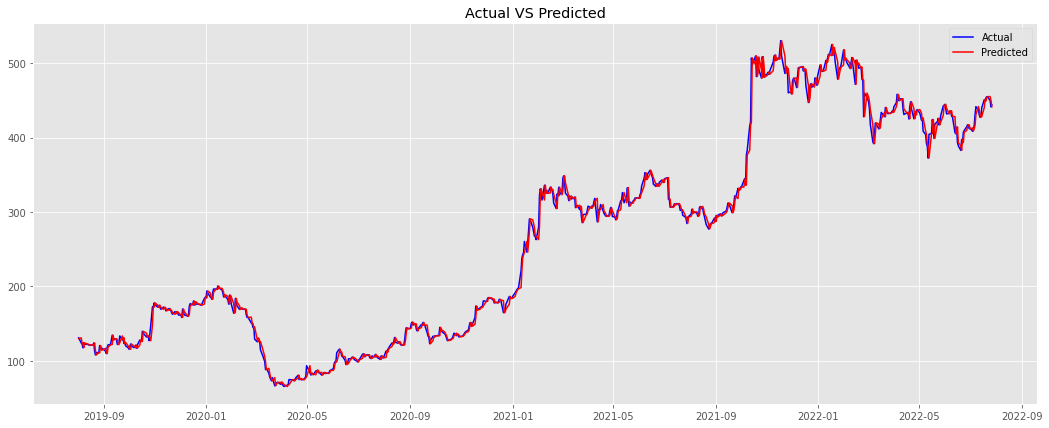

In [174]:
plt.figure(figsize=(18,7))
fig=plt.figure(1)
plt.plot(result["actual"],color='blue',label='Actual')
plt.plot(result["prediction"], color='red', label='Predicted')
plt.legend(loc = 'best')
plt.title('Actual VS Predicted')
plt.show(block = False)

In [166]:
model = ARIMA(y, order=(0,1,0))
model_fit = model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [171]:
forecast=model_fit.forecast(steps=10)[0]
np.exp(forecast)

array([444.18450631, 444.31906558, 444.45366561, 444.58830642,
       444.72298801, 444.85771041, 444.99247361, 445.12727764,
       445.26212251, 445.39700823])

In [191]:
pred_new = model_fit.predict(start=train.shape[0],end=(train.shape[0]+test.shape[0]-1), dynamic=False)

In [192]:
pred_new

Date
2019-08-02    0.000303
2019-08-05    0.000303
2019-08-06    0.000303
2019-08-07    0.000303
2019-08-08    0.000303
                ...   
2022-07-21    0.000303
2022-07-22    0.000303
2022-07-25    0.000303
2022-07-26    0.000303
2022-07-27    0.000303
Length: 740, dtype: float64

In [193]:
final = pd.DataFrame(np.exp(y))
final.columns = ["actual"]
final["prediction"] = np.exp(pred_new)
final

,actual,prediction
Date,,
2012-07-27,210.591202,NaN
2012-07-30,219.347275,NaN
2012-07-31,223.848999,NaN
2012-08-01,224.937317,NaN
2012-08-02,220.336670,NaN
...,...,...
2022-07-21,454.850006,1.000303
2022-07-22,454.899994,1.000303
2022-07-25,449.549988,1.000303
